# TA generalization error estimate, and ROC curves
- to rewrite

# TA linear and nonlinear fits

In [20]:
import tensorflow as tf

import keras
from scipy.sparse.linalg import lsmr
import statsmodels.api as sm

import random
from scipy.stats import pearsonr, spearmanr

import importlib
import myTools
importlib.reload(myTools)
from myTools import AA_ALPHABET,plot_corr_marginal, aa_to_oh, oh_to_aa, hamming, create_oh_mut, get_var_explain, get_mse, fit_log_model, log_layer, get_read_cut_data, fasta_iter_py3, get_subset_data, get_corr_metrics, get_subset_preds, get_all_n_to_var, plot_roc

import matplotlib.pyplot as plt

### get the right plt style
plt.style.use('/n/groups/marks/users/david/github/pareSingleLibrary2/codebase/src/paper_style1.mplstyle')

## adding the arial font that had to be downloaded
# following this: https://betterdatascience.com/python-matplotlib-fonts/
import matplotlib.font_manager as font_manager

# Add every font at the specified location
font_dir = ['/n/groups/marks/users/david/github/pareSingleLibrary2/codebase/src/fonts/']
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)

font_manager.findfont('arial') # font_manager.findfont('Arial') doesn't work
from matplotlib import rcParams
rcParams['font.family'] = 'arial'

# define output folder
dout = '/n/groups/marks/users/david/ex62/out/'


In [4]:
# loading the toxin-antitoxin data
%run ./loadAtData.py

/n/groups/marks/users/david/github/pareSingleLibrary2/codebase/pairedEnd/ex62_gvp/loadAtData.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mut_all_aa['aa_mut_1'] = df_mut_all_aa.muts.apply(lambda x: x.split(':')[0])
/n/groups/marks/users/david/github/pareSingleLibrary2/codebase/pairedEnd/ex62_gvp/loadAtData.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mut_all_aa['aa_mut_2'] = df_mut_all_aa.muts.apply(lambda x: x.split(':')[1])
/n/groups/marks/users/david/github/pareSingleLibrary2/codeba

# log reg fits

## 3 position nonlinear fit

2023-05-18 10:54:48.079603: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /n/app/gcc/6.2.0/lib64:/n/app/gcc/6.2.0/lib
2023-05-18 10:54:48.079671: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-18 10:54:48.079706: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (compute-a-17-65.o2.rc.hms.harvard.edu): /proc/driver/nvidia/version does not exist
2023-05-18 10:54:48.081081: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(61, 1)
layer0 weights set to:  [[ 0.08320744]
 [-0.06141881]
 [ 0.48644865]
 [ 0.22274233]
 [-0.06017357]]
beta_hat [ 0.08320745 -0.06141881  0.48644865  0.22274233 -0.06017357]


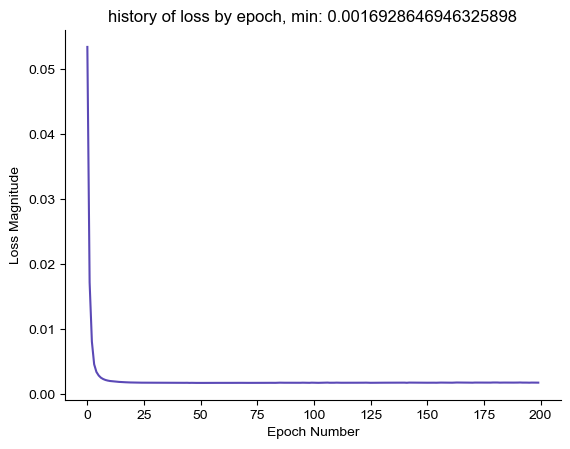

In [34]:
# training only on amino acid ones

lr=0.1
model_3p, history, callbacks =fit_log_model(X_3pos, Y_3pos, 
                                        my_layer=log_layer(1),
                                        adam_lr =0.1, 
                                         epochs=200,
                                         batch_size=1000)

Yhat_3pos_non= model_3p.predict(X_3pos).flatten()

var explained 0.9761818891571196
mse 0.0016832320700073194
pearsonr 0.9882190353737067
spearmanr 0.9864133601270748


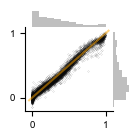

0.0016832320700073194
0.9761818891571196


In [35]:

plot_corr_marginal(Yhat_3pos_non, Y_3pos, 
                   figsize=(1.5,1.5),ticksize=7,
                   s=0.01, alpha=0.6,
                   c='grey',
                  fout = dout + 'pos3_nonlin_pred'
                  )

mse= get_mse(Yhat_3pos_non, Y_3pos)
print(mse)
print(get_var_explain(Yhat_3pos_non, Y_3pos))

(8000, 61) (8000,)
var explained 0.8738869680012681
mse 0.008912440676191454
pearsonr 0.9348192167479593
spearmanr 0.9552140494509889


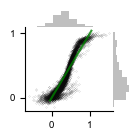

0.008912440676191454
0.8738869680012681


In [129]:


Y_3pos, yhat_lin_3pos =calc_lin_reg(X_3pos, Y_3pos)

plot_corr_marginal(yhat_lin_3pos, Y_3pos, 
                   figsize=(1.5,1.5),ticksize=7,
                   s=0.01, alpha=0.6,
                   c='grey',
                  fout = dout + 'pos3_lin_pred',
                  diag_col ='green',
                   diag_alpha=0.8
                  )

mse= get_mse(yhat_lin_3pos, Y_3pos)
print(mse)
print(get_var_explain(yhat_lin_3pos, Y_3pos))


In [110]:

df_yhats_y_3p = pd.DataFrame({'yobs':Y_3pos, 
                           'yhat_non':Yhat_3pos_non, 
                          'yhat_lin': yhat_lin_3pos})

## 4 pos

2022-12-05 20:46:37.063217: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /n/app/gcc/6.2.0/lib64:/n/app/gcc/6.2.0/lib
2022-12-05 20:46:37.063309: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-05 20:46:37.063352: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (compute-e-16-235.o2.rc.hms.harvard.edu): /proc/driver/nvidia/version does not exist
2022-12-05 20:46:37.066137: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(81, 1)
layer0 weights set to:  [[ 0.01031573]
 [ 0.        ]
 [-0.01686573]
 [-0.01131625]
 [ 0.        ]]
beta_hat [ 0.01031573  0.         -0.01686573 -0.01131625  0.        ]


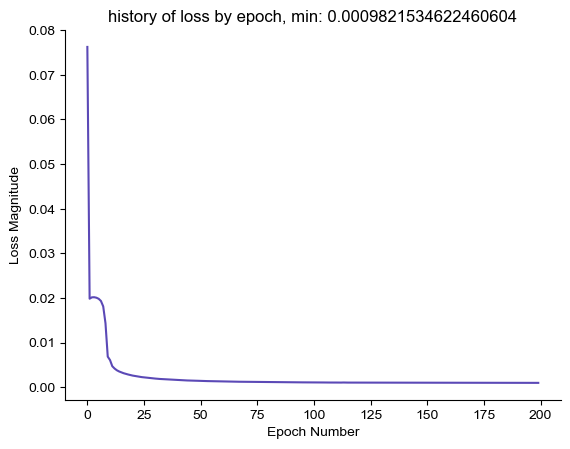

In [19]:
model_4p, history, callbacks =fit_log_model(X_4pos, Y_4pos, 
                                        my_layer=log_layer(1),
                                        adam_lr =0.1, 
                                         epochs=200,
                                         batch_size=1000,
                                         checkpoint_filepath = './tmp3/checkpoint')


In [20]:
Yhat_non_4pos= model_4p.predict(X_4pos).flatten()
plot_corr_marginal(Yhat_non_4pos, Y_4pos, 
                   c='grey', alpha=0.8, s=0.05, fout = dout + 'pos4_nonlin_pred',
                  diag_col ='black')

NameError: name 'model_4p' is not defined

In [33]:

calc_corr_above_fit(Yhat_non_4pos, Y_4pos)

PearsonRResult(statistic=0.9251394802356084, pvalue=5.550234331077848e-175)
SpearmanrResult(correlation=0.9286090751845452, pvalue=4.656684234931616e-179)


## 10 position

(201, 1)
layer0 weights set to:  [[ 0.01701156]
 [-0.01035653]
 [ 0.03116564]
 [ 0.00747865]
 [-0.03876103]]
beta_hat [ 0.01701156 -0.01035653  0.03116564  0.00747865 -0.03876103]


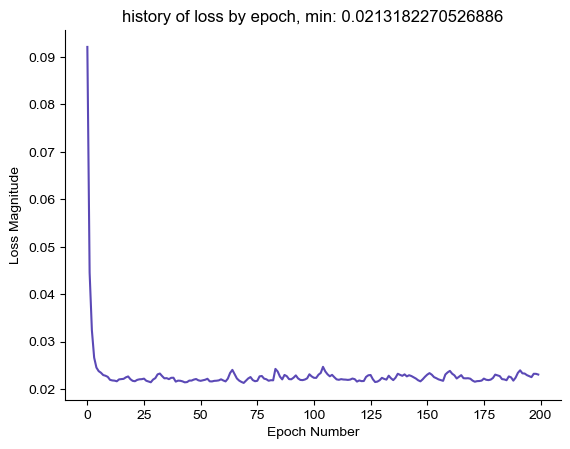

In [10]:
# renormed
model_10p_no_stop, history, callbacks =fit_log_model(
    X_10pos_rc3_no_stop,Y_10pos_rc3_no_stop, 
    my_layer=log_layer(1), # do not scale, just predict between 0 and 1
    adam_lr =0.1, 
    epochs=200,
    batch_size=1000)

Yhat_non_10pos_no_stop= model_10p_no_stop.predict(X_10pos_rc3_no_stop).flatten()


var explained 0.834556563118711
mse 0.02109011504398196
pearsonr 0.9144123121475116
spearmanr 0.7916202935082395


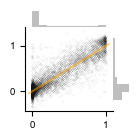

"\nplot_corr_marginal(Yhat_non_10pos_no_stop, Y_10pos_rc3_no_stop, \n                   c='grey', alpha=0.3, s=0.1, \n                   fout = dout + 'pos10_nonlin_pred_no_stop_renormed')#, plot_log_hist=True)\n"

In [10]:


plot_corr_marginal(Yhat_non_10pos_no_stop, Y_10pos_rc3_no_stop, 
                   figsize=(1.5,1.5),ticksize=7,
                   s=0.01, alpha=0.3,
                   c='grey',
                  fout = dout + 'pos10_nonlin_pred_no_stop_renormed'
                  )
'''
plot_corr_marginal(Yhat_non_10pos_no_stop, Y_10pos_rc3_no_stop, 
                   c='grey', alpha=0.3, s=0.1, 
                   fout = dout + 'pos10_nonlin_pred_no_stop_renormed')#, plot_log_hist=True)
'''

(8038, 201) (8038,)
var explained 0.6675191100631788
mse 0.04238342935129207
pearsonr 0.817018427003442
spearmanr 0.7638616289229186


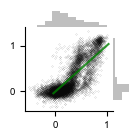

0.04238342935129207
0.6675191100631788


In [130]:
# linear regression
Y_10pos, yhat_lin_10pos =calc_lin_reg(
    X_10pos_rc3_no_stop,Y_10pos_rc3_no_stop)

plot_corr_marginal(yhat_lin_10pos, Y_10pos, 
                   figsize=(1.5,1.5),ticksize=7,
                   s=0.01, alpha=0.6,
                   c='grey',
                  fout = dout + 'pos10_lin_pred',
                   diag_col ='green',
                   diag_alpha=0.8
                  )

mse= get_mse(yhat_lin_10pos, Y_10pos)
print(mse)
print(get_var_explain(yhat_lin_10pos, Y_10pos))

# misc calculations

In [33]:
# correlation without dead ones
calc_corr_above_fit(Yhat_non_10pos_no_stop, Y_10pos_rc3_no_stop, cutoff=0.1)
calc_corr_above_fit(Yhat_non_10pos_no_stop, Y_10pos_rc3_no_stop)
calc_corr_above_fit(Yhat_non_10pos_no_stop, Y_10pos_rc3_no_stop, cutoff=0.3)


PearsonRResult(statistic=0.8601034842027274, pvalue=0.0)
SpearmanrResult(correlation=0.8563226435266953, pvalue=0.0)
PearsonRResult(statistic=0.7844477761095751, pvalue=0.0)
SpearmanrResult(correlation=0.7959344993179934, pvalue=0.0)
PearsonRResult(statistic=0.7315576460019574, pvalue=0.0)
SpearmanrResult(correlation=0.7578570270694377, pvalue=0.0)


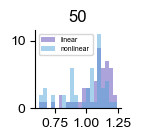

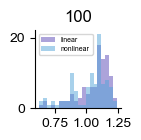

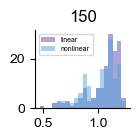

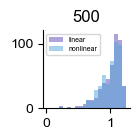

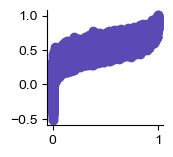

In [13]:
df_yhats_y = pd.DataFrame({'yobs':Y_10pos_rc3_no_stop, 
                           'yhat_non':Yhat_non_10pos_no_stop, 
                          'yhat_lin': yhat_lin_10pos})

for top_n_plot in [50,100,150, 500]:
    yobs_sort_by_non = df_yhats_y.sort_values('yhat_non', ascending=False)[:top_n_plot]
    yobs_sort_by_lin = df_yhats_y.sort_values('yhat_lin', ascending=False)[:top_n_plot]

    plt.figure(figsize=(1.5,1.5))
    plt.title(top_n_plot)
    n, bins, patches = plt.hist(yobs_sort_by_lin.yobs, alpha=0.5, label='linear', bins=20)

    n, bins, patches = plt.hist(yobs_sort_by_non.yobs, alpha=0.5,label='nonlinear',bins=bins)
    plt.legend(fontsize=5)
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(1.5,1.5))
plt.scatter(df_yhats_y.yhat_non, df_yhats_y.yhat_lin)
plt.show()

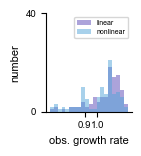

In [35]:
top_n_plot =100
yobs_sort_by_non = df_yhats_y.sort_values('yhat_non', ascending=False)[:top_n_plot]
yobs_sort_by_lin = df_yhats_y.sort_values('yhat_lin', ascending=False)[:top_n_plot]

plt.figure(figsize=(1.5,1.5))
n, bins, patches = plt.hist(yobs_sort_by_lin.yobs, alpha=0.5, label='linear', bins=20)

n, bins, patches = plt.hist(yobs_sort_by_non.yobs, alpha=0.5,label='nonlinear',bins=bins)
plt.legend(fontsize=5)
plt.tight_layout()
plt.xticks([0.9, 1], fontsize=7)
plt.yticks([0, 40], fontsize=7)
plt.xlabel('obs. growth rate', fontsize=8)
plt.ylabel('number', fontsize=8)

plt.savefig(dout+'10_pos_top_100_choose.svg', format='svg')
plt.show()

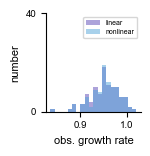

In [36]:
top_n_plot =100
yobs_sort_by_non = df_yhats_y_3p.sort_values('yhat_non', ascending=False)[:top_n_plot]
yobs_sort_by_lin = df_yhats_y_3p.sort_values('yhat_lin', ascending=False)[:top_n_plot]

plt.figure(figsize=(1.5,1.5))
n, bins, patches = plt.hist(yobs_sort_by_lin.yobs, alpha=0.5, label='linear', bins=20)

n, bins, patches = plt.hist(yobs_sort_by_non.yobs, alpha=0.5,label='nonlinear',bins=bins)
plt.legend(fontsize=5)
plt.tight_layout()
plt.xticks([0.9, 1], fontsize=7)
plt.yticks([0, 40], fontsize=7)
plt.xlabel('obs. growth rate', fontsize=8)
plt.ylabel('number', fontsize=8)

plt.savefig(dout+'3_pos_top_100_choose.svg', format='svg')
plt.show()

# ROC curves

## 90-10 for all 3 datasets

In [24]:
# fit the model


def fit_plot_train_test(x_train, y_train, x_test, y_test, n_out_pref = ''):
    print(n_out_pref)
    model, history, callbacks =fit_log_model(x_train, y_train, 
                                            my_layer=log_layer(1),
                                            adam_lr =0.1, 
                                            epochs=200,
                                            batch_size=1000, 
                                             verbose =False,
                                            checkpoint_filepath = './tmp/checkpoint{}'.format(random.sample(list(range(1000000)), 1)[0]))

    # for train set variance explained
    yhat_train= model.predict(x_train).flatten()
    var_exp_train, pearsonr_train, spearmanr_train = get_corr_metrics(yhat_train, y_train)

    # for the test dataset X
    yhat_test= model.predict(x_test).flatten()
    var_exp_test, pearsonr_test, spearmanr_test = get_corr_metrics(yhat_test, y_test)

    plot_corr_marginal(yhat_train, y_train, 
                       figsize=(1.5,1.5),ticksize=7,
                   s=0.01, alpha=0.6,
                   c='grey', fout = dout + n_out_pref+'90_10_train')
    plot_corr_marginal(yhat_test, y_test, 
                       figsize=(1.5,1.5),ticksize=7,
                   s=0.01, alpha=0.6,
                   c='grey', fout = dout + n_out_pref+'90_10_test')
    return yhat_train, yhat_test

### 10 pos

## 10 position: for the 80-20 split to have more true positives

10pos_80_20
var explained 0.8413115570928064
mse 0.020346050590935187
pearsonr 0.9178942624830017
spearmanr 0.7933026621855157


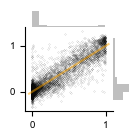

var explained 0.810039366036079
mse 0.02365515951200895
pearsonr 0.9004734033039641
spearmanr 0.7859913039739154


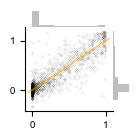

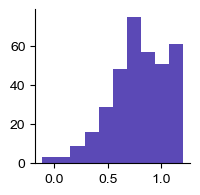

PPV is0.8579545454545454
10pos_80_20
var explained 0.8358705938794282
mse 0.020771981878737675
pearsonr 0.9144121958767113
spearmanr 0.7865679040290021


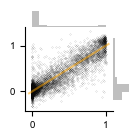

var explained 0.8321743678188271
mse 0.02199458544188848
pearsonr 0.9127015328722353
spearmanr 0.8124072352694002


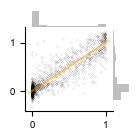

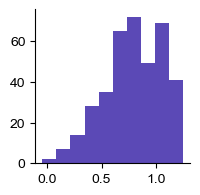

PPV is0.8586387434554974
10pos_80_20
var explained 0.840095165495726
mse 0.020273616319389533
pearsonr 0.9167484421910523
spearmanr 0.7938122116757582


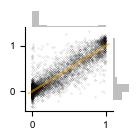

var explained 0.8180978727492331
mse 0.02368318614808976
pearsonr 0.9049509672603432
spearmanr 0.7848430066114493


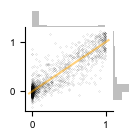

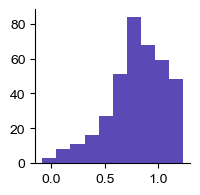

PPV is0.8693333333333333
average ppv: 0.861975540747792
average pearsonr: 0.9060419678121808


In [31]:
ppv_list_80_20 = []
pearson_list = []
for i in range(3):
    x_train, y_train, x_test, y_test = get_subset_data(X_10pos_rc3_no_stop,Y_10pos_rc3_no_stop, 
                                                       subset=0.8)
    yhat_train, yhat_test = fit_plot_train_test(x_train, y_train, x_test, y_test, n_out_pref = '10pos_80_20')
    df_yhats_y = pd.DataFrame({'yobs':y_test, 
                               'yhat_non':yhat_test, 
                            })

    # get positive predictive value
    plt.figure(figsize=(2,2))
    plt.hist(df_yhats_y.loc[df_yhats_y.yhat_non>0.5].yobs)

    plt.show()

    threshold=0.5
    df_pred_positives = df_yhats_y.loc[df_yhats_y.yhat_non>threshold]
    df_true_positives = df_pred_positives.loc[df_pred_positives.yobs > threshold]

    ppv = len(df_true_positives)/ len(df_pred_positives)
    print(f'PPV is{ppv}')
    pearson_list.append(pearsonr(y_test, yhat_test)[0])
    ppv_list_80_20.append(ppv)
print('average ppv:', np.mean(ppv_list_80_20))
print('average pearsonr:', np.mean(pearson_list))

In [30]:
len(x_test)

1608

0.5


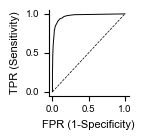

AUC 0.9710224044503617


In [33]:
plot_roc(df_yhats_y, 
         fname = dout+'ROC_10p_80_20', 
        n_thresh=20,
        true_thresh = 0.5)

In [20]:
df_test_results = pd.DataFrame({'yhat_test':yhat_test, 'y_test':y_test})

n_pred_above_half = len(df_test_results.loc[df_test_results.yhat_test>0.5])
n_pred_above_half_but_not_real_above_half = len(
    df_test_results.loc[(df_test_results.yhat_test>0.5)&(df_test_results.y_test<0.5)]
)

n_pred_above_half_and_real_above_half = len(
    df_test_results.loc[(df_test_results.yhat_test>0.5)&(df_test_results.y_test>0.5)]
)

print(n_pred_above_half)
print(n_pred_above_half_but_not_real_above_half)
print(n_pred_above_half_and_real_above_half)
34/189

print('precision:', n_pred_above_half_and_real_above_half/n_pred_above_half)

189
34
155
precision: 0.8201058201058201


### 3 pos 80-20

3pos_80_20
var explained 0.9769788167124999
mse 0.0016411681108092534
pearsonr 0.9885797997901193
spearmanr 0.9865909067423293


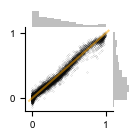

var explained 0.9730602643648378
mse 0.0018370366347884631
pearsonr 0.9866305423008193
spearmanr 0.9855331601097793


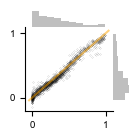

1600


In [34]:

x_train, y_train, x_test, y_test = get_subset_data(X_3pos, Y_3pos, 
                                                   subset=0.8)
yhat_train, yhat_test = fit_plot_train_test(x_train, y_train, x_test, y_test, n_out_pref = '3pos_80_20')
print(len(x_test))

0.5


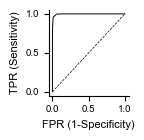

AUC 0.9976598639455783


In [36]:
df_yhats_y = pd.DataFrame({'yobs':y_test, 
                           'yhat_non':yhat_test, 
                        })
plot_roc(df_yhats_y, 
         fname = dout+ 'ROC_3p_80_20', 
        n_thresh=20,
        true_thresh = 0.5)

In [37]:
threshold=0.5
df_pred_positives = df_yhats_y.loc[df_yhats_y.yhat_non>threshold]
df_true_positives = df_pred_positives.loc[df_pred_positives.yobs > threshold]

ppv = len(df_true_positives)/ len(df_pred_positives)
print(f'PPV is{ppv}')

PPV is0.967654986522911


# misc

### 4pos

4pos_
var explained 0.9522619997597224
mse 0.0009673113324083919
pearsonr 0.9760039346745378
spearmanr 0.4864661907613041


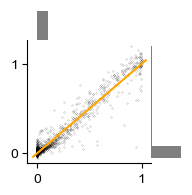

var explained 0.9309388504651275
mse 0.0011872253169712842
pearsonr 0.9652891968836189
spearmanr 0.49927672101609805


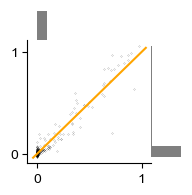

In [24]:
x_train, y_train, x_test, y_test = get_subset_data(X_4pos, Y_4pos, 
                                                   subset=0.9)
fit_plot_90_10(x_train, y_train, x_test, y_test, n_out_pref = '4pos_')

# misc

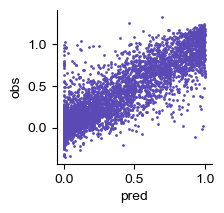

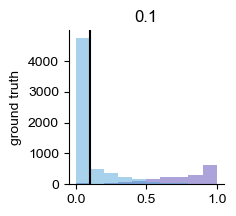

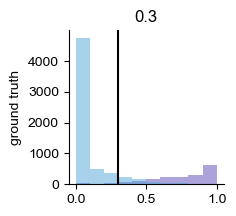

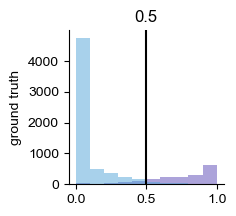

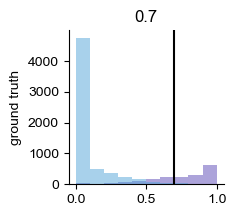

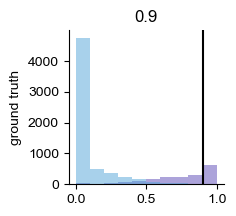

In [75]:
df_yhats_y
plt.figure(figsize=(2,2))
plt.scatter(df_yhats_y.yhat_non, df_yhats_y.yobs, s=1)
plt.xlabel('pred')
plt.ylabel('obs')
plt.show()

for t in [0.1, 0.3, 0.5, 0.7, 0.9]:
    plt.figure(figsize=(2,2))
    plt.hist(df_yhats_y.loc[df_yhats_y.yobs>0.5].yhat_non, alpha=0.5)
    plt.hist(df_yhats_y.loc[df_yhats_y.yobs<0.5].yhat_non, alpha=0.5)
    plt.axvline(t, c='black')
    plt.title(t)
    plt.ylabel('ground truth')
    plt.show()

    
# find ground truth positives and negatives
# plot their yhat-non scores, and then vary the threshold in classification using the yhat_non scores

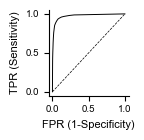

AUC 0.9737826113070538


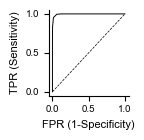

AUC 0.9968874818387365


In [116]:
# make AUROC

df_yhats_y.sort_values('yhat_non')


    
plot_roc(df_yhats_y, 
         fname = 'ROC_10p', 
        n_thresh=20,
        true_thresh = 0.5)

plot_roc(df_yhats_y_3p,
         fname = 'ROC_3p', 
        n_thresh=20,
        true_thresh = 0.5)

In [39]:
df_test_results = pd.DataFrame({'yhat_test':yhat_test, 'y_test':y_test})

n_pred_above_half = len(df_test_results.loc[df_test_results.yhat_test>0.5])
n_pred_above_half_but_not_real_above_half = len(
    df_test_results.loc[(df_test_results.yhat_test>0.5)&(df_test_results.y_test<0.5)]
)

n_pred_above_half_and_real_above_half = len(
    df_test_results.loc[(df_test_results.yhat_test>0.5)&(df_test_results.y_test>0.5)]
)

print(n_pred_above_half)
print(n_pred_above_half_but_not_real_above_half)
print(n_pred_above_half_and_real_above_half)
34/189

print('precision:', n_pred_above_half_and_real_above_half/n_pred_above_half)

197
5
192
precision: 0.9746192893401016


10pos_
var explained 0.8370112032137524
mse 0.020998703947468927
pearsonr 0.9151150101326609
spearmanr 0.7966174070199247


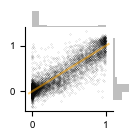

var explained 0.8112646534736145
mse 0.021685866759749203
pearsonr 0.9013423633931253
spearmanr 0.7582967170568167


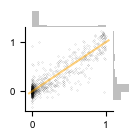

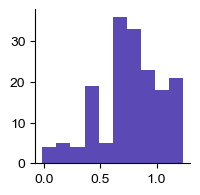

PPV is0.8095238095238095
10pos_
var explained 0.8387051692014269
mse 0.02063894572061294
pearsonr 0.9166625650473049
spearmanr 0.7933792734881181


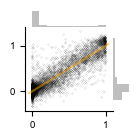

var explained 0.8058931605551574
mse 0.023865643345358345
pearsonr 0.8983212561781035
spearmanr 0.7883491320850718


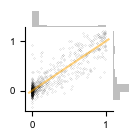

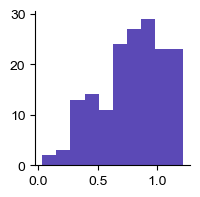

PPV is0.8165680473372781
10pos_
var explained 0.8419001323381653
mse 0.020157148184453272
pearsonr 0.9179064903240289
spearmanr 0.7935075249447789


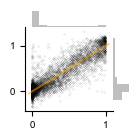

var explained 0.7790642406275579
mse 0.02810488056529471
pearsonr 0.88336378568369
spearmanr 0.7843860269672319


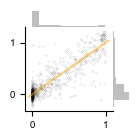

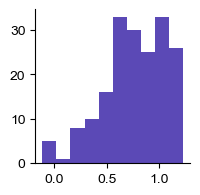

PPV is0.8181818181818182
10pos_
var explained 0.8365715854350884
mse 0.020968096392716434
pearsonr 0.9149462965955539
spearmanr 0.7913821713728875


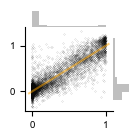

var explained 0.8242004187886477
mse 0.021104950505251286
pearsonr 0.9084247816104614
spearmanr 0.785120283362174


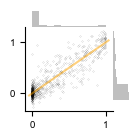

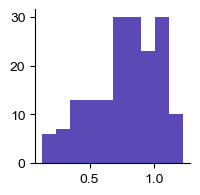

PPV is0.8285714285714286
10pos_
var explained 0.8387407450841929
mse 0.0206196839058231
pearsonr 0.9158989616295462
spearmanr 0.7934889881455964


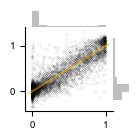

var explained 0.8122453886793737
mse 0.023262815666929493
pearsonr 0.9014088345309665
spearmanr 0.790714356285574


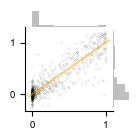

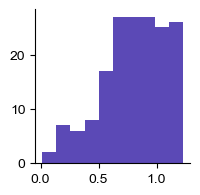

PPV is0.8662790697674418
10pos_
var explained 0.8396318551944882
mse 0.020655590732696093
pearsonr 0.9164656503498734
spearmanr 0.7942365039027497


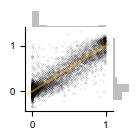

var explained 0.7982734236921458
mse 0.023232678989587634
pearsonr 0.8940989610029814
spearmanr 0.7773066527224797


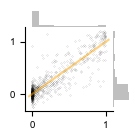

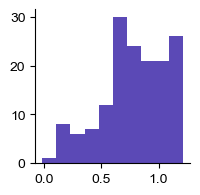

PPV is0.8269230769230769
average ppv: 0.8276745417174755


In [16]:
# position at library 90-10 train test split and PPV calculations
ppv_list_90_10 = []
for i in range(6):
    x_train, y_train, x_test, y_test = get_subset_data(X_10pos_rc3_no_stop,Y_10pos_rc3_no_stop, 
                                                       subset=0.9)
    yhat_train, yhat_test = fit_plot_train_test(x_train, y_train, x_test, y_test, n_out_pref = '10pos_')
    df_yhats_y = pd.DataFrame({'yobs':y_test, 
                               'yhat_non':yhat_test, 
                            })
    # get positive predictive value
    plt.figure(figsize=(2,2))
    plt.hist(df_yhats_y.loc[df_yhats_y.yhat_non>0.5].yobs)

    plt.show()

    threshold=0.5
    df_pred_positives = df_yhats_y.loc[df_yhats_y.yhat_non>threshold]
    df_true_positives = df_pred_positives.loc[df_pred_positives.yobs > threshold]

    ppv = len(df_true_positives)/ len(df_pred_positives)
    print(f'PPV is{ppv}')
    ppv_list_90_10.append(ppv)
print('average ppv:', np.mean(ppv_list_90_10))

10pos_
var explained 0.8382042262993805
mse 0.020599452476610994
pearsonr 0.9156807620472088
spearmanr 0.7913031298637174


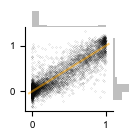

var explained 0.8146320237794766
mse 0.023874363136282023
pearsonr 0.9032706086814684
spearmanr 0.7990774536762792


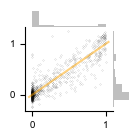

In [132]:
# old 90-10 train-test run
x_train, y_train, x_test, y_test = get_subset_data(X_10pos_rc3_no_stop,Y_10pos_rc3_no_stop, 
                                                   subset=0.9)
yhat_train, yhat_test = fit_plot_train_test(x_train, y_train, x_test, y_test, n_out_pref = '10pos_')
df_yhats_y = pd.DataFrame({'yobs':y_test, 
                           'yhat_non':yhat_test, 
                        })

### roc for 90-10

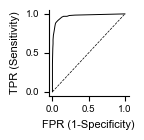

AUC 0.9721555591360463


In [121]:
df_yhats_y = pd.DataFrame({'yobs':y_test, 
                           'yhat_non':yhat_test, 
                        })
plot_roc(df_yhats_y, 
         fname = 'ROC_10p_90_10', 
        n_thresh=20,
        true_thresh = 0.5)